# Quickstart AltaiPony: De-trend and find flares

Let's first get the base class and the IO function we want to use:

In [1]:
from altaipony.flarelc import FlareLightCurve
from altaipony.lcio import from_mast

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Now download a **K2SC** light curve from archive and create a ``FlareLightCurve``.


In [30]:
EPIC = 211983544
# c is the campaign for K2, sector for TESS, and quarter for Kepler
flc = from_mast(EPIC, mode="TPF", mission="K2", c=18)

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/K2/ktwo211983544-c18_lc/ktwo211983544-c18_lpd-targ.fits.gz with expected size 1528838.
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


Let's verify that we succeeded:

In [31]:
flc

FlareLightCurve(ID: 211983544)

The representation tells us that we have indeed created a ``FlareLightCurve``.

Now let's look at some cool tools we inherited from the awesome [``lightkurve``](https://github.com/KeplerGO/lightkurve) package:

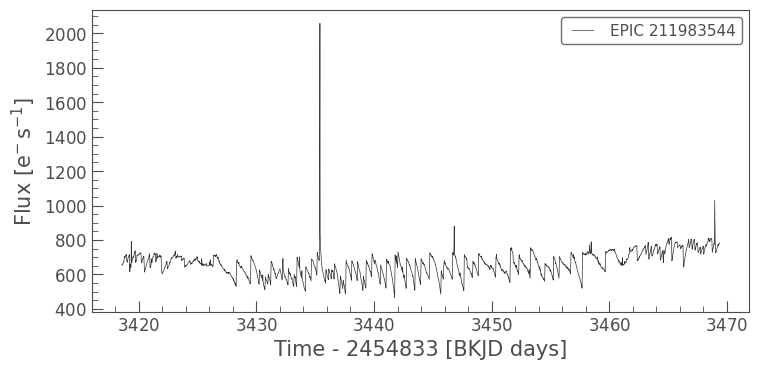

In [32]:
%matplotlib inline
flc.plot();

This is the raw light curve. The is intrumental noise but also stellar variability. Let's remove it with K2SC:

In [33]:
flcd = flc.detrend("k2sc")

Starting initial outlier detection at 3sigma.
  Flagged 108 ( 4.6%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    1.69 (fap 2.1878e-257 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -2898.953966555301
  DE iteration %3i -ln(L) %4.1f 1 -2898.953966555301
  DE iteration %3i -ln(L) %4.1f 2 -2898.953966555301
  DE iteration %3i -ln(L) %4.1f 3 -2898.953966555301
  DE iteration %3i -ln(L) %4.1f 4 -2898.953966555301
  DE iteration %3i -ln(L) %4.1f 5 -2917.449719140568
  DE iteration %3i -ln(L) %4.1f 6 -2917.449719140568
  DE iteration %3i -ln(L) %4.1f 7 -2917.449719140568
  DE iteration %3i -ln(L) %4.1f 8 -2917.449719140568
  DE iteration %3i -ln(L) %4.1f 9 -2917.449719140568
  DE iteration %3i -ln(L) %4.1f 10 -2917.449719140568
  DE iteration %3i -ln(L) %4.1f 11 -2928.663783450733
  DE iteration %3i -ln(L) %4.1f 12 -2928.663783450733
  DE iteration %3i 

De-trending successfully completed.


  CDPP - raw - %6.3f 38206.02193436747
  CDPP - position component removed - %6.3f 7151.592379690445
  CDPP - full reduction - %6.3f 2168.551565653062
Detrending time 304.060289144516


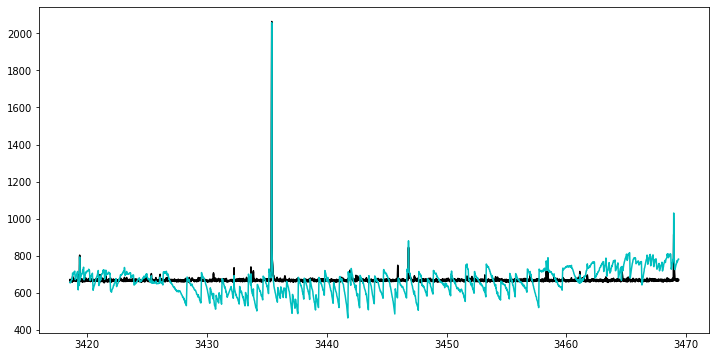

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(flcd.time, flcd.detrended_flux, c='k')
plt.plot(flcd.time, flcd.detrended_flux + flcd.detrended_flux_err*3, c='k')
plt.plot(flcd.time, flcd.flux, c='c')

**K2SC** preserved flare signal, so this is what we use for flare finding.

So let us find the flares in this light curve (one, at least, is pretty obvious, right?)

Often, the uncertainty in the detrended flux is underestimated, and we need a better proxy for the noise. for simplicity, we choose to increase the noise level by a factor of three, but you can also pick the standard deviation of the residuals or some other metric. 

In [46]:
flcd.detrended_flux_err = flcd.detrended_flux_err * 3
flcd.detrended_flux_err

array([6.004618 , 6.004755 , 6.003885 , ..., 6.1921673, 6.1937847,
       6.193541 ], dtype=float32)

In [49]:
flcd = flcd.find_flares()
flcd.flares.sort_values(by="ed_rec", ascending=False)

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,775,786,162792,162803,3435.361892,3435.586643,7426.566315,30.294153,2.098369,0.224751,2371.0
4,2351,2354,164437,164441,3468.972071,3469.053797,1672.864361,39.374319,0.371776,0.081726,2371.0
2,1311,1314,163352,163355,3446.803711,3446.865006,764.340370,24.095903,0.266223,0.061295,2371.0
1,1080,1085,163113,163119,3441.920517,3442.043108,427.698711,37.436218,0.077577,0.122591,2371.0
3,2155,2158,164225,164228,3464.640564,3464.701859,302.246228,27.862309,0.071419,0.061295,2371.0


Aha! Some flare candidates. Not all visible outliers qualify for flare candidates, because we require a minimum a minimum of three outliers in a row for any candidate. We also apply a set of other criteria, which you can read up on [here in the docs](https://altaipony.readthedocs.io/en/latest/tutorials/altai.html).


Let's see where they are in the light curve and zoom in on the big one:

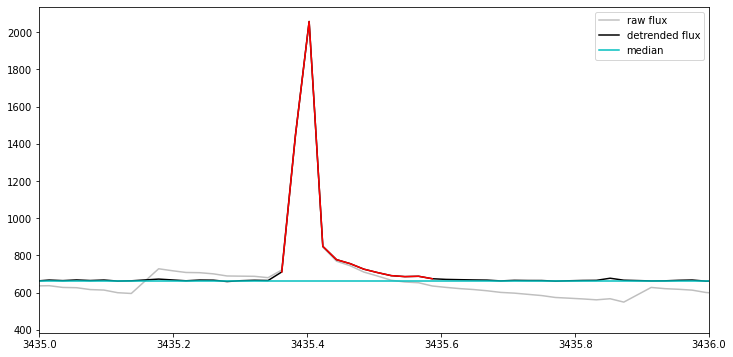

In [51]:
plt.figure(figsize=(12,6))
plt.plot(flcd.time, flcd.flux, c='grey', alpha=.5, label='raw flux')
plt.plot(flcd.time, flcd.detrended_flux, c='k', label='detrended flux')
plt.plot(flcd.time, flcd.it_med, c='c', label='median')
for i,f in flcd.flares.iterrows():
    plt.plot(flcd.time[f.istart:f.istop+1], flcd.detrended_flux[f.istart:f.istop+1], c='r')
plt.xlim(3435,3436)
#plt.xlim(3464,3465) # uncomment this and the line below to see a small candidate
#plt.ylim(600,900) # uncomment this and the line above to see a small candidate zoomed in
plt.legend();

Not all of them are real, others are real but are detected only by chance. Here is where injecting synthetic events comes in. But this is a story for a different notebook, and is a computational challenge if you wish to quantify the effects that K2SC GP de-trending has on the flare energies and recovery probabilities.

Questions? Something does not work? Email me @ eilin@aip.de 